Plots win rate of baseline attacks.

In [14]:
import os
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

from sgf_parser import game_info
import utils

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)

In [51]:
dfs = []
directory = "/nas/ucb/ttseng/go_attack/baseline-attack/20221122-rescored"
for file in os.listdir(directory):
    path = directory / pathlib.Path(file)
    if path.suffix != ".sgfs":
        continue
    features = path.stem.split("-")
    victim_name = features[0]
    num_visits = int(features[1][1:])
    victim_color = features[2]
    policy = features[-1]

    df = pd.DataFrame(
        game_info.read_and_parse_file(path, fast_parse=True, victim_color=victim_color)
    )
    df["victim_name"] = victim_name
    df["victim_visits"] = num_visits
    df["adv_name"] = policy
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df["adv_win"] = df["adv_color"] == df["win_color"]
print(len(df))

9600


In [67]:
results = df.groupby(["victim_name", "victim_color", "adv_name", "victim_visits"]).mean(
    numeric_only=True
)
print(results.adv_win)
print(results.adv_minus_victim_score)

victim_name  victim_color  adv_name  victim_visits
cp505        b             edge      1                0.49375
                                     2                0.51250
                                     4                0.53750
                                     8                0.51250
                                     16               0.34375
                                     32               0.13750
                           mirror    1                0.07500
                                     2                0.00000
                                     4                0.02500
                                     8                0.01250
                                     16               0.00625
                                     32               0.01875
                           spiral    1                0.04375
                                     2                0.03125
                                     4                0.03750
                   

In [83]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# Need to be consistent with colors across different plots.
policy_to_color = {
    "edge": colors[0],
    "mirror": colors[2],
    "spiral": colors[1],
}


def generate_plots(df, column, y_lower, y_upper):
    assert column in ["adv_win", "adv_minus_victim_score"]
    column_label = {"adv_win": "Win \%", "adv_minus_victim_score": "Win margin"}[column]
    y_multiplier = {
        "adv_win": 100,
        "adv_minus_victim_score": 1,
    }[column]

    for victim_name in sorted(df["victim_name"].unique()):
        victim_name_df = df.query(f"victim_name == '{victim_name}'")
        for victim_color in sorted(df["victim_color"].unique()):
            fig, axs = plt.subplots(
                1,
                1,
                constrained_layout=True,
                figsize=(utils.TWO_COL_PLOT_WIDTH, 2),
                dpi=240,
            )

            victim_df = victim_name_df.query(f"victim_color == '{victim_color}'")
            for adv_name in sorted(victim_df["adv_name"].unique()):
                color = policy_to_color[adv_name]
                data = victim_df.query(f"adv_name == '{adv_name}'")
                (
                    y_multiplier
                    * data.groupby("victim_visits").mean(numeric_only=True)[column]
                ).plot(label=adv_name, color=color)

                if column == "adv_win":
                    # Plot confidence intervals
                    df_confint = data.groupby("victim_visits").mean(True)
                    conf_df = df_confint.apply(
                        lambda x: proportion_confint(
                            len(
                                data[(data["victim_visits"] == x.name) & (data.adv_win)]
                            ),
                            len(data[data["victim_visits"] == x.name]),
                            alpha=0.05,
                            # Generate Clopper-Pearson confidence intervals:
                            # https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
                            method="beta",
                        ),
                        axis=1,
                        result_type="expand",
                    )
                    plt.fill_between(
                        df_confint.index,
                        conf_df[0] * y_multiplier,
                        conf_df[1] * y_multiplier,
                        alpha=0.3,
                        color=color,
                    )

            victim_label = "\\texttt{Latest}"
            if victim_name == "cp505h":
                victim_label += "_\\texttt{def}"
            plt.ylabel(f"{column_label} vs. ${victim_label}$ ({victim_color.upper()})")
            plt.ylim(y_lower, y_upper)
            plt.xscale("log")
            plt.xlabel("Victim visits")
            plt.legend()

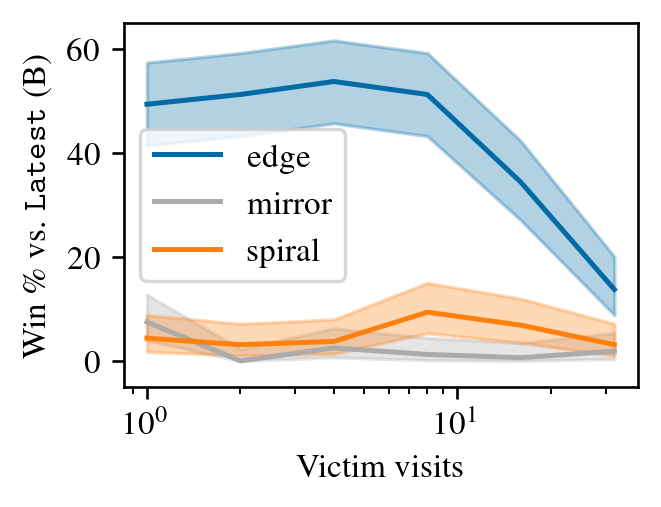

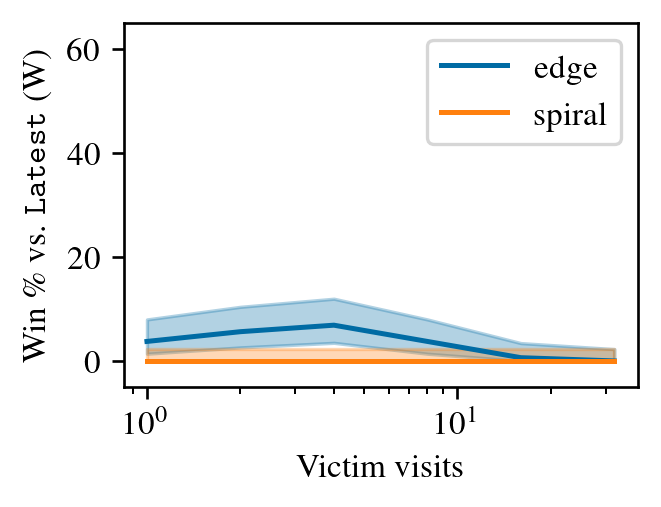

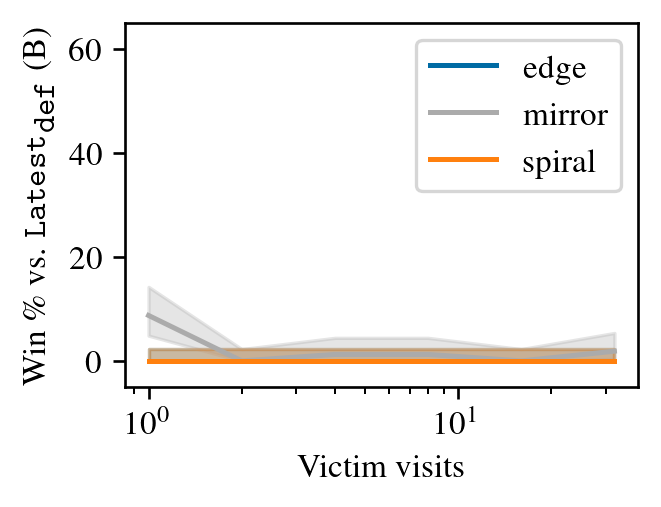

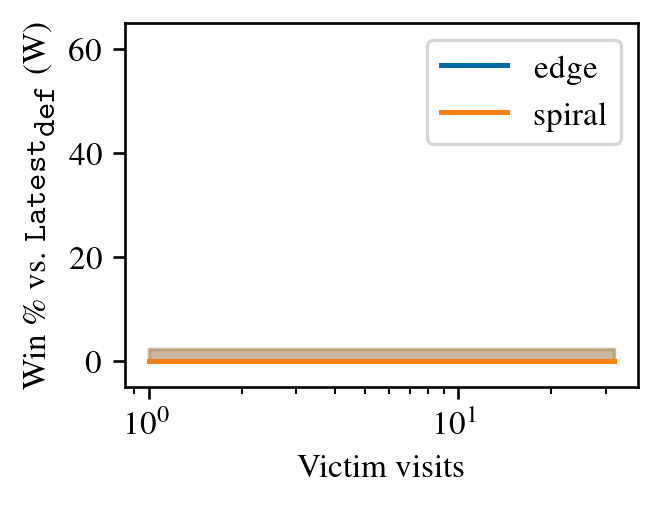

In [84]:
generate_plots(df, "adv_win", y_lower=-5, y_upper=65)

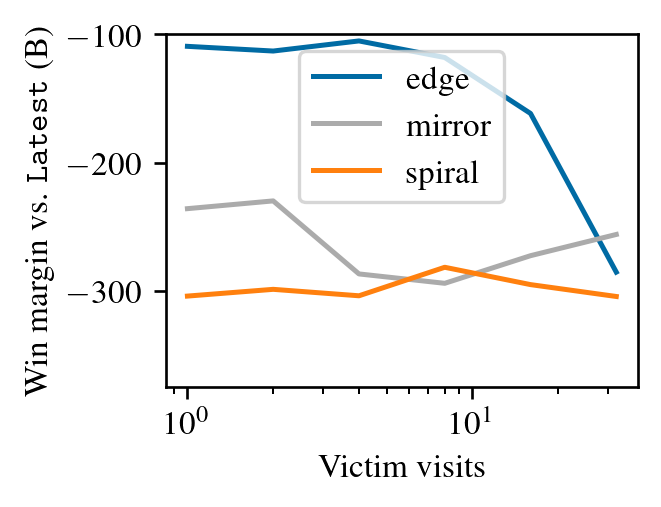

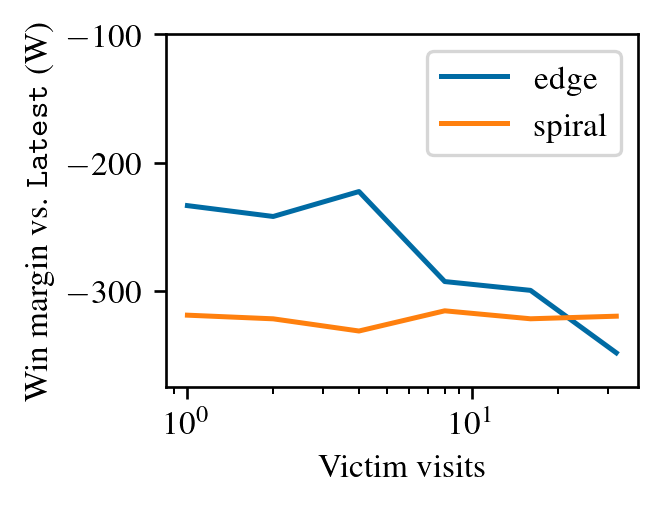

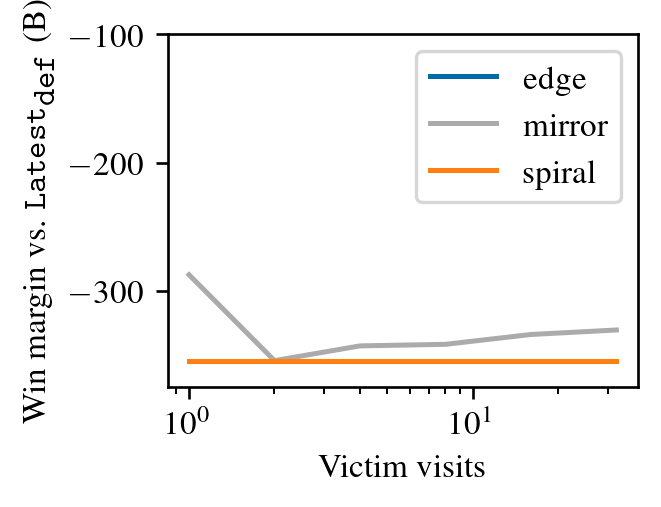

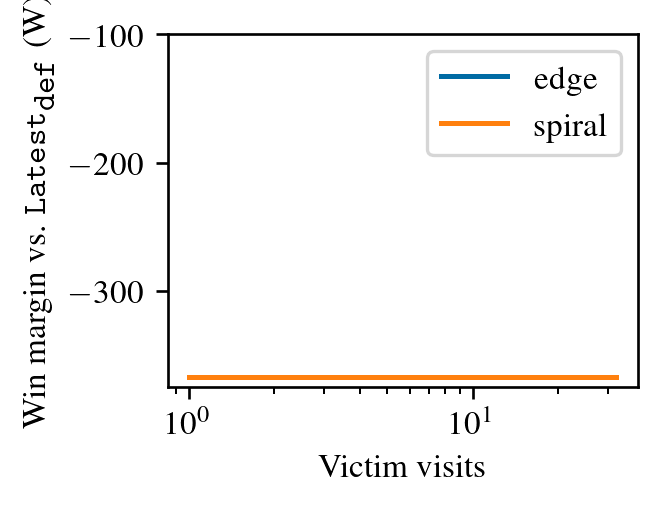

In [85]:
generate_plots(df, "adv_minus_victim_score", y_lower=-375, y_upper=-100)